# Find matching fragment pairs

Conditions
- dummy atoms have complementary subpockets
- dummy atoms have identical BRICS environment
- dummy atoms have same bond type

## 1. Load Fragment library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path

import pandas as pd
#import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Lipinski, PandasTools

from kinfraglib import utils
from kinfraglib import filters

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [6]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply Filters to fragment library

### 2.1. Prefilters

In [7]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(
    fragment_library)

In [8]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

### 2.2. unwanted substructures

In [9]:
pains_dict = filters.pains.get_pains(fragment_library)

In [10]:
fragment_library_filtered = pains_dict["fragment_library"]
pains_df = pains_dict["pains"]

In [11]:
HERE = Path(_dh[-1])
DATA =  HERE / '../../../Brenk'

In [12]:
brenk_dict = filters.unwanted_substructures.get_brenk(fragment_library_filtered, DATA)

Number of unwanted substructures in Brenk et al. collection: 104


In [13]:
fragment_library_filtered =  brenk_dict['fragment_library']
brenk_structs = brenk_dict['brenk']

### 2.3. Drug likeness

In [14]:
druglikeness_dict = filters.ruleofthree.get_ro3_frags(fragment_library_filtered)
fragment_library_filtered = druglikeness_dict["fragment_library"]
ro3_vals = druglikeness_dict["ro3"]

In [15]:
res_qed = filters.qed.get_qed(fragment_library_filtered)
fragment_library_filtered = res_qed["fragment_library"]
qed_vals = res_qed["qed"]

### 2.4. Synthesizability

In [16]:
synthesizability_dict = filters.building_blocks.check_building_blocks(
    fragment_library_filtered,
    str(str(PATH_DATA)+'/filters/DataWarrior/Enamine_Building_Blocks.sdf'))

In [17]:
fragment_library_filtered = synthesizability_dict['fragment_library']

In [18]:
d_sybas = filters.syba.calc_syba(
    fragment_library_filtered,
    cutoff=0)

In [19]:
fragment_library_filtered = d_sybas['fragment_library']
sybascore = d_sybas['sybas']

### 2.5. save only fragments passing all filters

In [20]:
fragment_library_filtered = filters.analysis.number_of_accepted(
    fragment_library_filtered, columns=['bool_pains', 'bool_brenk', 'ro3', 'qed', 'bool_bb', 'bool_syba'],
    min_accepted=6)

In [21]:
complete_fragment_library_filtered = fragment_library_filtered

In [22]:
for subpocket in fragment_library_filtered.keys():
    fragment_library_filtered[subpocket].drop(fragment_library_filtered[subpocket].loc[fragment_library_filtered[subpocket]['bool']==0].index, inplace=True)
    fragment_library_filtered[subpocket] = fragment_library_filtered[subpocket].reset_index(drop=True)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,fragment_count,connections,connections_name,bool_pains,bool_brenk,ro3,qed,bool_bb,bool_syba,bool
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,1,1,1,1,1
1,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,...,9,[SE],[AP=SE],1,1,1,1,1,1,1
2,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,...,10,"[SE, GA]","[AP=SE, AP=GA]",1,1,1,1,1,1,1
3,AP,Nc1cc(C2CC2)[nH]n1,,,,ACTR2,STKR,TKL,3soc,GVD,...,5,[SE],[AP=SE],1,1,1,1,1,1,1
4,AP,Cc1c[nH]c2ncncc12,,,,AKT1,Akt,AGC,3mv5,XFE,...,2,[FP],[AP=FP],1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,AP,Nc1ccnn1-c1ccccc1,,,,p38a,MAPK,CMGC,3ocg,OCG,...,1,[GA],[AP=GA],1,1,1,1,1,1,1
210,AP,O=c1[nH]cncc1Cl,,,,p38a,MAPK,CMGC,3roc,29A,...,1,"[GA, SE]","[AP=GA, AP=SE]",1,1,1,1,1,1,1
211,AP,O=C1CCCCc2ccccc21,,,,p38a,MAPK,CMGC,3uvp,048,...,1,[GA],[AP=GA],1,1,1,1,1,1,1
212,AP,c1coc(-c2nc[nH]n2)c1,,,,p38a,MAPK,CMGC,5xyx,FTZ,...,1,[GA],[AP=GA],1,1,1,1,1,1,1

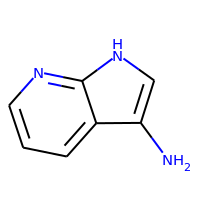
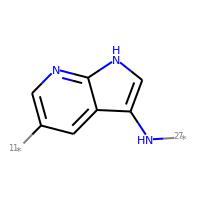
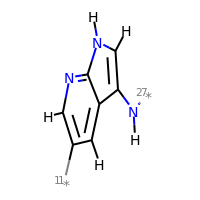
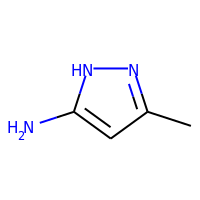
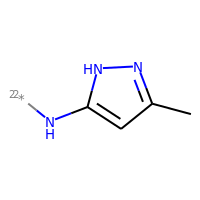
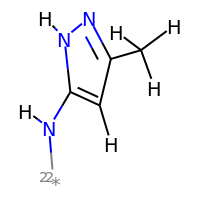
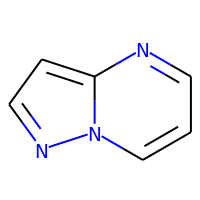
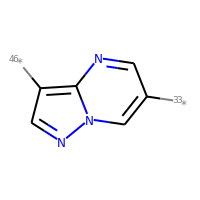
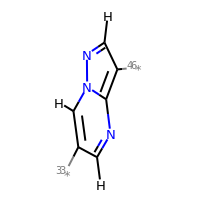
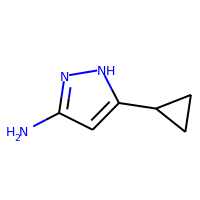
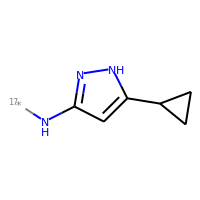
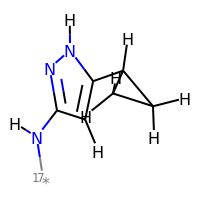
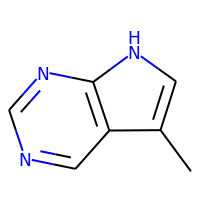
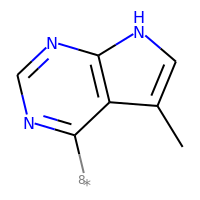
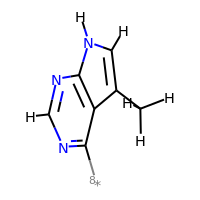
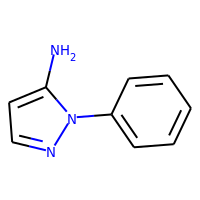
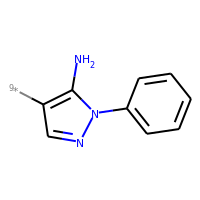
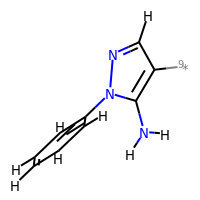
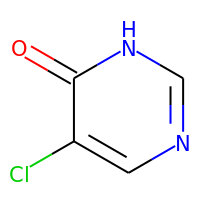
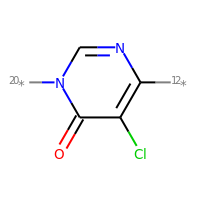
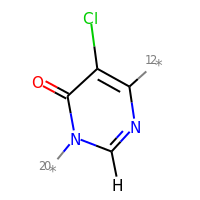
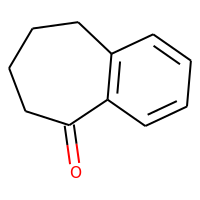
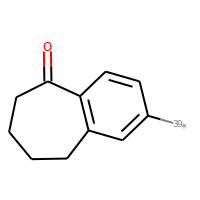
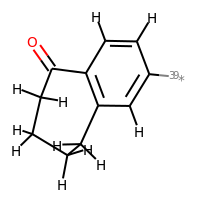
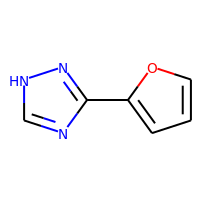
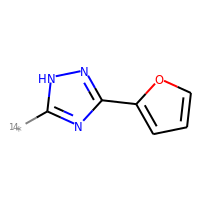
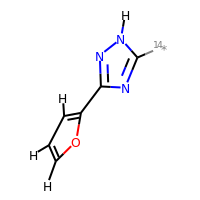
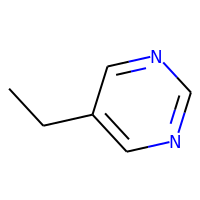
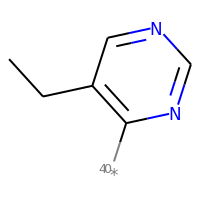
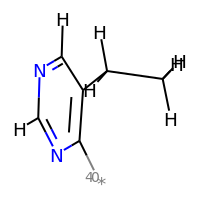

In [23]:
fragment_library_filtered['AP']

## 3. Get matching fragment pairs and check conditions

using https://github.com/volkamerlab/KinaseFocusedFragmentLibrary/blob/b7e684c26f75efffc2a9ba2383c9027cdd4c29a3/kinase_focused_fragment_library/recombination/cli.py#L205

In [24]:
from kinase_focused_fragment_library.recombination.classes_meta import \
    Combination, Compound, Port, Fragment

from kinase_focused_fragment_library.recombination.brics_rules import is_brics_bond
from rdkit.Chem.PropertyMol import PropertyMol
from functools import reduce
from kinase_focused_fragment_library.recombination.get_tuple import get_tuple

In [25]:
def get_valid_pairs(fragment_library):
    """
        *copied and adapted from kinase_focused_fragment_library*
    """
    data = {}  # (Fragments)
    frag_set = set()  # only used in initialization for avoiding duplicates in fragment data set (smiles & dummy atoms)

    #iterate through subpockets and fragments in subpockets
    #save subpocket_fragmentindex and dummy atoms, bonds etc
    for subpocket in fragment_library.keys():
        fragments = []
        for i, row in fragment_library[subpocket].iterrows():
            #get fragment and connecting subpockets
            fragment = row['ROMol_original']
            fragment = Chem.RemoveHs(fragment)
            frag_id = f'{subpocket}_{i}'
            
            # store unique atom identifiers
            for a, atom in enumerate(fragment.GetAtoms()):
                frag_atom_id = f'{subpocket}_{a}'
                atom.SetProp('frag_atom_id', frag_atom_id)
                
            # get all dummy atoms of this fragment except the ones corresponding to the X pool
            dummy_atoms = [a for a in fragment.GetAtoms() if a.GetSymbol() == '*' and not a.GetProp('subpocket').startswith('X')]
            if not dummy_atoms:
                continue
            
            frag_smiles, dummy_set = get_tuple(fragment, dummy_atoms)
            # check if this exact fragment has already been found
            if (frag_smiles, dummy_set) in frag_set:
                continue
            # if not, add this fragment to set of fragments
            frag_set.add((frag_smiles, dummy_set))

            # create dummy atom objects
            ports = [Port(atom_id=dummy.GetProp('frag_atom_id'), subpocket=subpocket, neighboring_subpocket=dummy.GetProp('subpocket'),
                          bond_type=fragment.GetBondBetweenAtoms(dummy.GetIdx(), dummy.GetNeighbors()[0].GetIdx()).GetBondType(),
                          environment=dummy.GetNeighbors()[0].GetProp('environment'))
                     for dummy in dummy_atoms]   
            # add all dummy atoms of this fragment to the queue
            compound = Compound(frag_ids=[frag_id], subpockets=[subpocket], ports=ports, bonds=[])
            combo = Combination(frag_ids=frozenset([frag_id]))
            
            # store fragment in constant data set
            fragment = Fragment(frag_id=frag_id, subpocket=subpocket, ports=ports)
            fragments.append(fragment)
        data[subpocket] = fragments
        
    n_frags = len(frag_set)

    print('Number of fragments: ', n_frags)
    
    return data

In [26]:
def checkvalid(data, fragment_library):
    matches = [] #save matching fragment pairs
    #iterate through subpockets
    for subpocket in fragment_library.keys():
        #iterate through fragments in subpockets
        for fragment in data[subpocket]:
            fragment_id1 = fragment.frag_id #store fragment ID of first fragment in pair
            #go through atom connnections and check neighbors, bond type and environment
            for i in range(0,len(fragment.ports)):
                neighbor = fragment.ports[i].neighboring_subpocket
                bond_type = fragment.ports[i].bond_type
                environment = fragment.ports[i].environment
                match = [] #store current matching fragment pair
                for frag2 in data[neighbor]:
                    fragment_id2 = frag2.frag_id  #store fragment ID of second fragment            
                    for i in range(0,len(frag2.ports)): 
                        #check environment type, subpocket, bond type
                        environment_match = is_brics_bond(environment, frag2.ports[i].environment) #check if BRICS environments are able to form connection
                        #if subpocket is adjacent, bond type is eqal and environments are matching, add as valid matching pair
                        if frag2.ports[i].neighboring_subpocket == subpocket and neighbor ==  frag2.ports[i].subpocket and frag2.ports[i].bond_type == bond_type and environment_match:
                            match.append([fragment_id1, fragment_id2])        
                matches.append(match) #add valid matching pair to list of matching pairs
    return matches  

In [27]:
res = get_valid_pairs(fragment_library_filtered)

Number of fragments:  842


In [28]:
valids = checkvalid(res, fragment_library_filtered)

In [29]:
valids[0]

[['AP_0', 'FP_0'],
 ['AP_0', 'FP_1'],
 ['AP_0', 'FP_2'],
 ['AP_0', 'FP_4'],
 ['AP_0', 'FP_5'],
 ['AP_0', 'FP_6'],
 ['AP_0', 'FP_13'],
 ['AP_0', 'FP_14'],
 ['AP_0', 'FP_15'],
 ['AP_0', 'FP_16'],
 ['AP_0', 'FP_17'],
 ['AP_0', 'FP_18'],
 ['AP_0', 'FP_19'],
 ['AP_0', 'FP_20'],
 ['AP_0', 'FP_21'],
 ['AP_0', 'FP_22'],
 ['AP_0', 'FP_23'],
 ['AP_0', 'FP_24'],
 ['AP_0', 'FP_25'],
 ['AP_0', 'FP_26'],
 ['AP_0', 'FP_28'],
 ['AP_0', 'FP_29'],
 ['AP_0', 'FP_30'],
 ['AP_0', 'FP_31'],
 ['AP_0', 'FP_34'],
 ['AP_0', 'FP_35'],
 ['AP_0', 'FP_36'],
 ['AP_0', 'FP_38'],
 ['AP_0', 'FP_39'],
 ['AP_0', 'FP_40'],
 ['AP_0', 'FP_41'],
 ['AP_0', 'FP_44'],
 ['AP_0', 'FP_45'],
 ['AP_0', 'FP_46'],
 ['AP_0', 'FP_47'],
 ['AP_0', 'FP_48'],
 ['AP_0', 'FP_49'],
 ['AP_0', 'FP_50'],
 ['AP_0', 'FP_51'],
 ['AP_0', 'FP_52'],
 ['AP_0', 'FP_55'],
 ['AP_0', 'FP_58'],
 ['AP_0', 'FP_59'],
 ['AP_0', 'FP_62'],
 ['AP_0', 'FP_63'],
 ['AP_0', 'FP_65'],
 ['AP_0', 'FP_66'],
 ['AP_0', 'FP_67'],
 ['AP_0', 'FP_77'],
 ['AP_0', 'FP_78'],
 ['AP_

### combine fragment pairs

In [30]:
def get_bonds(valids, data, fragment_library):
    bonds = [] #store bonds of valid matching pairs as atom IDs where connection is formed
    #go through all valid pairs
    for valid in valids:
        bond = []
        for val in valid:
            #load fragments that should get connected
            subpocket1 = val[0].split("_")[0]
            fragment1_index = int(val[0].split("_")[1])
            fragment1 = fragment_library[subpocket1]["ROMol_original"][fragment1_index] 
            #remove Hs before finding bonds otherwise bond ids not correct because for combining molecules without Hs are used
            fragment1 = Chem.RemoveHs(fragment1)
            
            subpocket2 = val[1].split("_")[0]
            fragment2_index = int(val[1].split("_")[1])
            fragment2 = fragment_library[subpocket2]["ROMol_original"][fragment2_index] 
            #remove Hs before finding bonds
            fragment2 = Chem.RemoveHs(fragment2)
            
            #i = 0
            bond1_id = None
            bond2_id = None
        
            
            data1 = data[subpocket1][fragment1_index] #get corresponding connection to load environment, bond type and neighboring subpocket
            for i in range(0,len(data1.ports)):
                environment1 = data1.ports[i].environment
                bond_type1 = data1.ports[i].bond_type
                neighbor1 = data1.ports[i].neighboring_subpocket
                
                data2 = data[subpocket2][fragment2_index] #for matching fragment also get the connection data
                for j in range(0,len(data2.ports)):
                    environment2 = data2.ports[j].environment
                    bond_type2 = data2.ports[j].bond_type
                    neighbor2 = data2.ports[j].neighboring_subpocket
                    
                    #check again if BRICS bond, bond types and subpockets are matching for a connection
                    if  is_brics_bond(environment1, environment2) and bond_type1 == bond_type2 and subpocket2 == neighbor1 and subpocket1 == neighbor2:
                        #get atom indices where connection is build
                        for atom in fragment1.GetAtoms():
                            atom_symbol = atom.GetSymbol()
                            if atom_symbol == "*":
                                bond1_id = subpocket1 + "_" + str(atom.GetIdx())
                        
                        for atom2 in fragment2.GetAtoms():
                            atom_symbol2 = atom2.GetSymbol()
                            if atom_symbol2 == "*":
                                bond2_id = subpocket2 + "_" + str(atom2.GetIdx())
                        
            bond.append([bond1_id, bond2_id, bond_type1]) #save atom indices and bond type for building the connection
        bonds.append(bond)
    return bonds

In [31]:
bonds = get_bonds(valids, res, fragment_library_filtered)

In [32]:
#bonds for pair
bonds[0][1]

['AP_11', 'FP_10', rdkit.Chem.rdchem.BondType.SINGLE]

In [33]:
def construct_ligand(fragment_ids, bond_ids, fragment_library):
    """
    *copied and adapted from kinase_focused_fragment_library*
    Construct a ligand by connecting multiple fragments based on a Combination object
    Parameters
    ----------
    fragment_ids: list of str
        Fragment IDs of recombined ligand, e.g. `["SE_2", "AP_0", "FP_2"]` (`<subpocket>_<fragment index in subpocket pool>`).
    bond_ids : list of list of str
        Bond IDs of recombined ligand, e.g. `[["FP_6", "AP_10"], ["AP_11", "SE_13"]]`: Atom (`<subpocket>_<atom ID>`) pairs per fragment bond.
    fragment_library : dict of pandas.DataFrame
        SMILES and RDKit molecules for fragments (values) per subpocket (key).
    Returns
    -------
    ligand: rdkit.Chem.rdchem.Mol or None
        Recombined ligand (or None if the ligand could not be constructed)
    """

    fragments = []
    for fragment_id in fragment_ids:

        # Get subpocket and fragment index in subpocket
        subpocket = fragment_id.split("_")[0]
        fragment_index = int(fragment_id.split("_")[1])
        fragment = fragment_library[subpocket].ROMol_original[fragment_index]

        # Store unique atom identifiers in original molecule (important for recombined ligand construction based on atom IDs)
        fragment = Chem.RemoveHs(fragment)
        for i, atom in enumerate(fragment.GetAtoms()):
            fragment_atom_id = f"{subpocket}_{i}"
            atom.SetProp("fragment_atom_id", fragment_atom_id)
            atom.SetProp("fragment_id", fragment.GetProp("complex_pdb"))
        fragment = PropertyMol(fragment)

        # Append fragment to list of fragments
        fragments.append(fragment)

    # Combine fragments using map-reduce model
    combo = reduce(Chem.CombineMols, fragments)

    bonds_matching = True
    ed_combo = Chem.EditableMol(combo)
    replaced_dummies = []

    atoms = combo.GetAtoms()
    
    
    #for bond in bond_ids:

    dummy_1 = next(
            atom for atom in combo.GetAtoms() if atom.GetProp("fragment_atom_id") == bond_ids[0]
    )
    dummy_2 = next(
            atom for atom in combo.GetAtoms() if atom.GetProp("fragment_atom_id") == bond_ids[1]
    )
    atom_1 = dummy_1.GetNeighbors()[0]
    atom_2 = dummy_2.GetNeighbors()[0]

    # check bond types
    bond_type_1 = combo.GetBondBetweenAtoms(dummy_1.GetIdx(), atom_1.GetIdx()).GetBondType()
    bond_type_2 = combo.GetBondBetweenAtoms(dummy_2.GetIdx(), atom_2.GetIdx()).GetBondType()
    if bond_type_1 != bond_type_2:
        bonds_matching = False
        print("Bonds not matching")

    ed_combo.AddBond(atom_1.GetIdx(), atom_2.GetIdx(), order=bond_type_1)

    replaced_dummies.extend([dummy_1.GetIdx(), dummy_2.GetIdx()])

    # Do not construct this ligand if bond types are not matching
    if not bonds_matching:
        return

    # Remove replaced dummy atoms
    replaced_dummies.sort(reverse=True)
    for dummy in replaced_dummies:
        ed_combo.RemoveAtom(dummy)

    ligand = ed_combo.GetMol()

    # Replace remaining dummy atoms with hydrogens
    du = Chem.MolFromSmiles("*")
    h = Chem.MolFromSmiles("[H]", sanitize=False)
    ligand = AllChem.ReplaceSubstructs(ligand, du, h, replaceAll=True)[0]
    try:
        ligand = Chem.RemoveHs(ligand)
    except ValueError:
        print(Chem.MolToSmiles(ligand))
        return

    # Clear properties
    for prop in ligand.GetPropNames():
        ligand.ClearProp(prop)
    for atom in ligand.GetAtoms():
        atom.ClearProp("fragment_atom_id")

    # Generate 2D coordinates
    AllChem.Compute2DCoords(ligand)

    return ligand

In [34]:
def get_pairs(valids, bonds, fragment_library_filtered):
    pairs = []
    frags1 = []
    frags2 = []
    ids = []
    for i in range(0, len(valids)):
        for j in range(0, len(valids[i])):
            frag1 = fragment_library_filtered[valids[i][j][0].split("_")[0]]['ROMol_dummy'][int(valids[i][j][0].split("_")[1])]
            frag2 = fragment_library_filtered[valids[i][j][1].split("_")[0]]['ROMol_dummy'][int(valids[i][j][1].split("_")[1])]
            
            frags1.append(frag1)
            frags2.append(frag2)
            
            pair = construct_ligand(valids[i][j], bonds[i][j], fragment_library_filtered)
            pairs.append(pair)
            ids.append(valids[i][j])
            
    return pd.DataFrame({'fragment ids': ids, 'fragment1':frags1, 'fragment2':frags2, 'pair':pairs})

In [35]:
pair_df = get_pairs(valids, bonds, fragment_library_filtered)

Bonds not matching
Bonds not matching
Bonds not matching
Bonds not matching
Bonds not matching
Bonds not matching


,fragment ids,fragment1,fragment2,pair
0,"[AP_0, FP_0]",,,
1,"[AP_0, FP_1]",,,
2,"[AP_0, FP_2]",,,
3,"[AP_0, FP_4]",,,
4,"[AP_0, FP_5]",,,
...,...,...,...,...
98819,"[B2_31, GA_64]",,,
98820,"[B2_31, GA_66]",,,
98821,"[B2_31, GA_74]",,,
98822,"[B2_31, GA_109]",,,

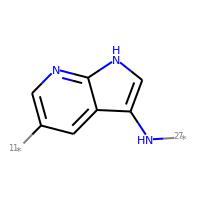
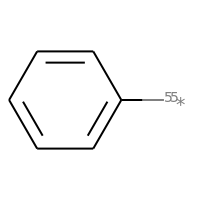
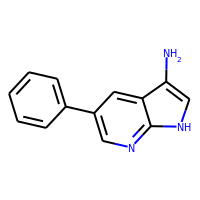
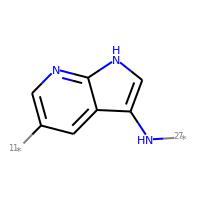
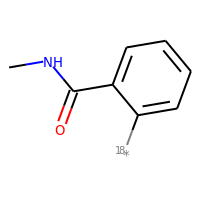
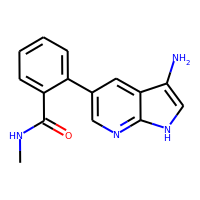
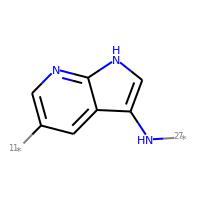
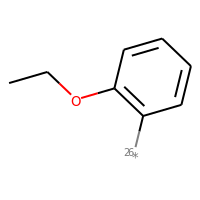
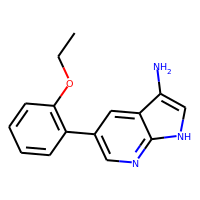
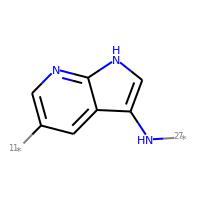
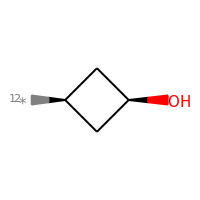
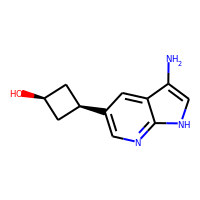
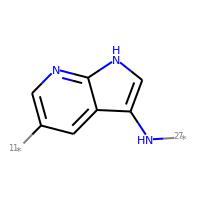
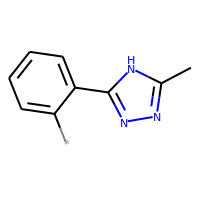
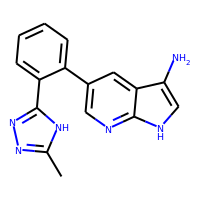
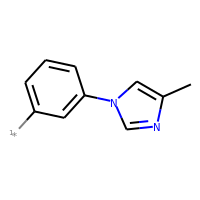
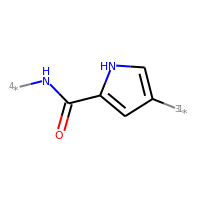
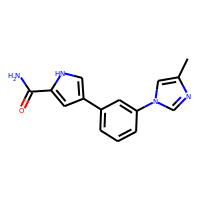
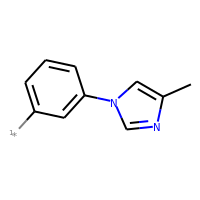
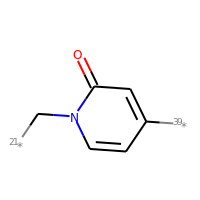
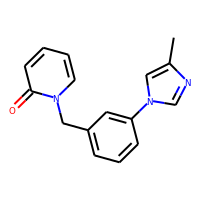
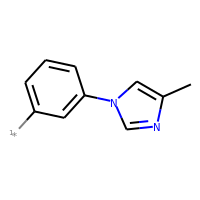
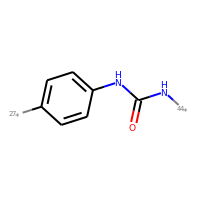
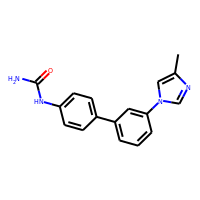
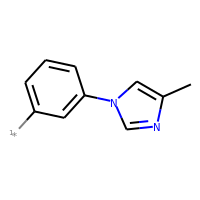
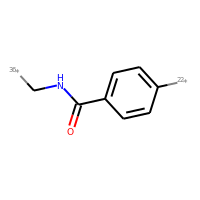
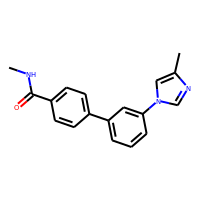
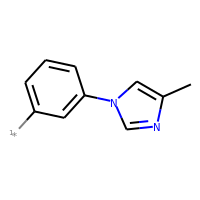
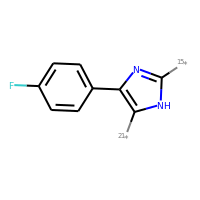
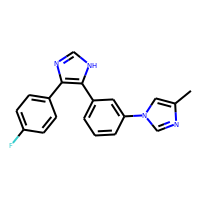

In [36]:
pair_df

In [37]:
pair_0 = pair_df['pair'][1]

In [38]:
pairfrag1 = pair_df['fragment1'][1]
pairfrag2 = pair_df['fragment2'][1]

In [39]:
Chem.MolToSmiles(pairfrag1)

'[11*]c1cnc2[nH]cc(N[27*])c2c1'

In [40]:
Chem.MolToSmiles(pairfrag2)

'[18*]c1ccccc1C(=O)NC'

In [41]:
Chem.MolToSmiles(pair_0)

'CNC(=O)c1ccccc1-c1cnc2[nH]cc(N)c2c1'

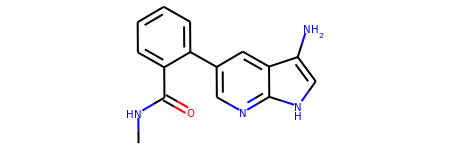

In [42]:
pair_0

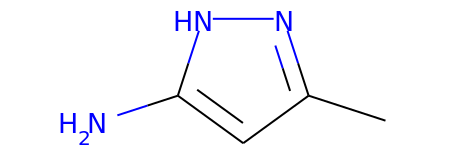

In [43]:
Chem.MolFromSmiles('Nc1cc(C)n[nH]1')

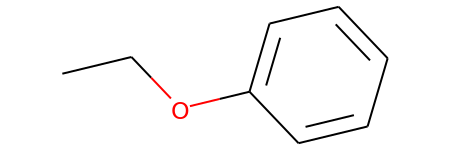

In [44]:
Chem.MolFromSmiles('CCOc1ccccc1')

In [45]:
Chem.MolToSmiles(fragment_library_filtered['SE']['ROMol'][2])

'Cc1ccccn1'

In [46]:
Chem.MolToSmiles(fragment_library_filtered['AP']['ROMol'][0])

'Nc1c[nH]c2ncccc12'

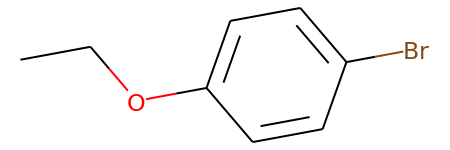

In [47]:
Chem.MolFromSmiles('CCOc1ccc(Br)cc1')

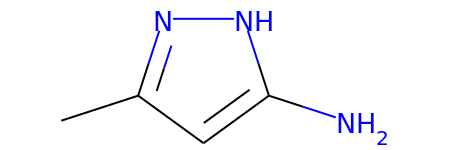

In [48]:
Chem.MolFromSmiles('Cc1cc(N)[nH]n1')

In [49]:
pairfrag1.HasSubstructMatch(Chem.MolFromSmiles('Cc1cc(N)[nH]n1'))

False

## ASKCOS retrosynthesis

In [116]:
import requests
from pprint import pprint
HOST = 'https://askcos.mit.edu/'
params = {
    'smiles': 'CCOc1ccc(Nc2cc(C)n[nH]2)cc1', # required
    #'smiles': 'Nc1c[nH]c2ncc(-c3ccccc3)cc12',
    
    # optional with defaults shown
    'max_depth': 1, # maximum number of reaction steps
    'max_branching': 25, # ?max number of branches are looked at to find "best"?
    'expansion_time': 60, # how long the expansion can run
    'max_ppg': 100, # maximum price per gram
    'template_count': 100, 
    'max_cum_prob': 0.995, # which common probability reached until no more templates are used
    'chemical_property_logic': 'none', # molecules are buyable or not, can be 'none' (only price relevant), 'and' (price and heavy atoms constraint) or 'or' (one of both constraints is relevant) 
    'max_chemprop_c': 0, # max heavy atom contraints if 'and' or 'or' is used in 'chemical_property_logic'
    'max_chemprop_n': 0,
    'max_chemprop_o': 0,
    'max_chemprop_h': 0,
    'chemical_popularity_logic': 'none', # want to use popular chemicals as reasonable stopping points?
    'min_chempop_reactants': 5, # min frequence as popular reactant
    'min_chempop_products': 5, #min frequence as popular prouct
    'filter_threshold': 0.75, 
    
    'return_first': 'true' # default is false
}
resp = requests.get(HOST+'/api/treebuilder/', params=params, verify=False)
pprint(resp.json())

/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'askcos.mit.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'request': {'chemical_popularity_logic': ['none'],
             'chemical_property_logic': ['none'],
             'expansion_time': ['60'],
             'filter_threshold': ['0.75'],
             'max_branching': ['25'],
             'max_chemprop_c': ['0'],
             'max_chemprop_h': ['0'],
             'max_chemprop_n': ['0'],
             'max_chemprop_o': ['0'],
             'max_cum_prob': ['0.995'],
             'max_depth': ['1'],
             'max_ppg': ['100'],
             'min_chempop_products': ['5'],
             'min_chempop_reactants': ['5'],
             'return_first': ['true'],
             'smiles': ['CCOc1ccc(Nc2cc(C)n[nH]2)cc1'],
             'template_count': ['100']},
 'trees': [{'as_product': 2,
            'as_reactant': 0,
            'children': [{'children': [{'as_product': 22,
                                        'as_reactant': 368,
                                        'children': [],
                                        'id': 5,
             

In [117]:
len(resp.json()['trees'])

2

In [84]:
resp.json()['trees'][0]['children'][0]['plausibility']

0.911036551

In [91]:
len(resp.json()['trees'][0]['children']) # number of childrens found

1

In [89]:
len(resp.json()['trees'][0]['children'][0]['children']) # number of children, should alsways be 2

2

In [92]:
resp.json()['trees'][0]['children'][0]['children']

[{'as_product': 68,
  'smiles': 'CCOc1ccc(Br)cc1',
  'children': [],
  'is_chemical': True,
  'ppg': 1.0,
  'id': 1,
  'as_reactant': 314},
 {'as_product': 47,
  'smiles': 'Cc1cc(N)[nH]n1',
  'children': [],
  'is_chemical': True,
  'ppg': 5.0,
  'id': 2,
  'as_reactant': 859}]

In [93]:
resp.json()['trees'][0]['children'][0]['children'][0]

{'as_product': 68,
 'smiles': 'CCOc1ccc(Br)cc1',
 'children': [],
 'is_chemical': True,
 'ppg': 1.0,
 'id': 1,
 'as_reactant': 314}

In [94]:
resp.json()['trees'][0]['children'][0]['children'][0]['smiles']

'CCOc1ccc(Br)cc1'

In [95]:
resp.json()['trees'][0]['children'][0]['children'][0]['ppg']

1.0

In [96]:
resp.json()['trees'][0]['children'][0]['children'][1]

{'as_product': 47,
 'smiles': 'Cc1cc(N)[nH]n1',
 'children': [],
 'is_chemical': True,
 'ppg': 5.0,
 'id': 2,
 'as_reactant': 859}

In [97]:
resp.json()['trees'][0]['children'][0]['children'][1]['smiles']

'Cc1cc(N)[nH]n1'

In [98]:
resp.json()['trees'][0]['children'][0]['children'][1]['ppg']

5.0

In [145]:
#not working. Check API request and output manually first
def get_retro(pairs, fragment_library):
    children1 = []
    children2 = []
    plausibilities = []
    for i, row in pairs.iterrows():
        cur_pair = row['pair']
        # get fragments from fragment library without dummy atoms (otherwise comparison not possible)
        #cur_frag1 = row['fragment1']
        #cur_frag2 = row['fragment2']
        cur_frag1 = fragment_library[pairs['fragment ids'][i][0].split('_')[0]]['ROMol'][int(pairs['fragment ids'][i][0].split('_')[1])]
        cur_frag2 = fragment_library[pairs['fragment ids'][i][1].split('_')[0]]['ROMol'][int(pairs['fragment ids'][i][1].split('_')[1])]
        
        pair_smiles = Chem.MolToSmiles(cur_pair)
        retro = call_retro(pair_smiles)
        
        if(len(retro['trees'])) > 0:
            #ToDo: include check how many results --> best plausibility used?
            if len(retro['trees'][0]['children'][0]['children']) == 2:
                plausibility = retro['trees'][0]['children'][0]['plausibility']
                child1 = retro['trees'][0]['children'][0]['children'][0]['smiles']
                price1 = retro['trees'][0]['children'][0]['children'][0]['ppg']
                child2 = retro['trees'][0]['children'][0]['children'][1]['smiles']
                price2 = retro['trees'][0]['children'][0]['children'][1]['ppg']
                child1_mol = Chem.MolFromSmiles(child1)
                child2_mol = Chem.MolFromSmiles(child2)

                if child1_mol.Chem.HasSubstructureMatch(cur_frag1) and child2_mol.Chem.HasSubstructureMatch(cur_frag2):
                    children1.append(child1_mol)
                    children2.append(child2_mol)
                    plausibilities.append(plausibility)
                else if child2_mol.Chem.HasSubstructureMatch(cur_frag1) and child1_mol.Chem.HasSubstructureMatch(cur_frag2):
                    children1.append(child2_mol)
                    children2.append(child1_mol)
                    plausibilities.append(plausibility)
                else:
                    children1.append(None)
                    children2.append(None)
                    plausibilities.append(0)
            else:
                    children1.append(None)
                    children2.append(None)
                    plausibilities.append(0)
        #ToDo: check if fragments are substructures of children
        #ToDo: chek if where dummy atom is some functional group????
    pairs['children_1']=children1
    pairs['children_2']=children2
    pairs['pausibility']=plausibilities
    
    return pairs
        
import requests
from pprint import pprint       
def call_retro(pair_smiles):

    HOST = 'https://askcos.mit.edu/'
    params = {
        'smiles': pair_smiles, # required

        # optional with defaults shown
        'max_depth': 1, # maximum number of reaction steps
        'max_branching': 25, # ?max number of branches are looked at to find "best"?
        'expansion_time': 20, # how long the expansion can run
        'max_ppg': 100, # maximum price per gram
        'template_count': 100, 
        'max_cum_prob': 0.995, # which common probability reached until no more templates are used
        'chemical_property_logic': 'none', # molecules are buyable or not, can be 'none' (only price relevant), 'and' (price and heavy atoms constraint) or 'or' (one of both constraints is relevant) 
        'max_chemprop_c': 0, # max heavy atom contraints if 'and' or 'or' is used in 'chemical_property_logic'
        'max_chemprop_n': 0,
        'max_chemprop_o': 0,
        'max_chemprop_h': 0,
        'chemical_popularity_logic': 'none', # want to use popular chemicals as reasonable stopping points?
        'min_chempop_reactants': 5, # min frequence as popular reactant
        'min_chempop_products': 5, #min frequence as popular prouct
        'filter_threshold': 0.75, 

        'return_first': 'true' # default is false
    }
    resp = requests.get(HOST+'/api/treebuilder/', params=params, verify=False)
    return resp.json()

SyntaxError: invalid syntax (<ipython-input-145-fc52b6b681c9>, line 31)

,fragment ids,fragment1,fragment2,pair
0,"[AP_0, FP_0]",,,
1,"[AP_0, FP_1]",,,
2,"[AP_0, FP_2]",,,
3,"[AP_0, FP_4]",,,
4,"[AP_0, FP_5]",,,
5,"[AP_0, FP_6]",,,
6,"[AP_0, FP_13]",,,
7,"[AP_0, FP_14]",,,
8,"[AP_0, FP_15]",,,
9,"[AP_0, FP_16]",,,

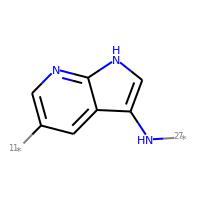
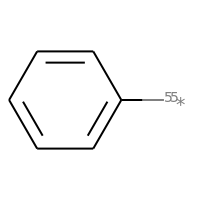
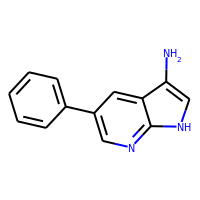
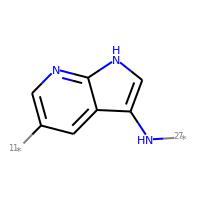
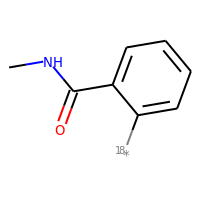
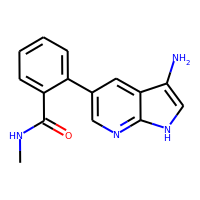
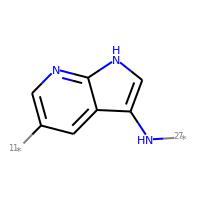
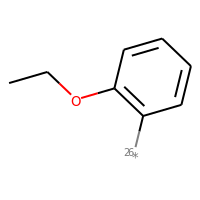
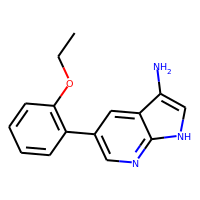
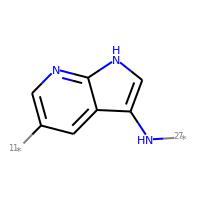
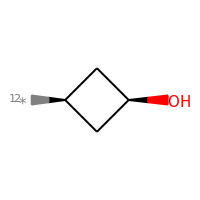
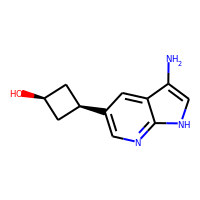
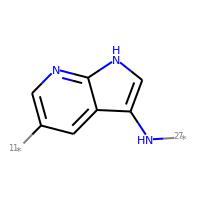
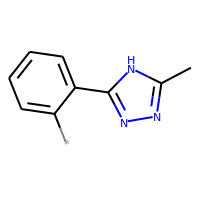
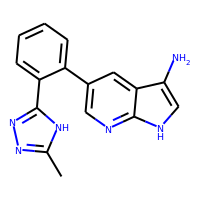
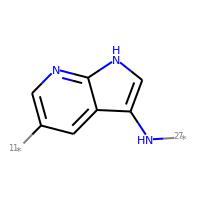
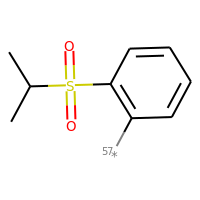
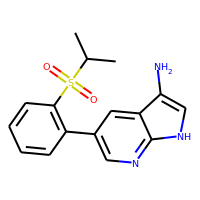
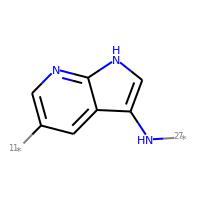
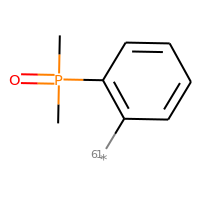
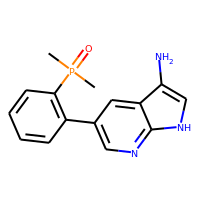
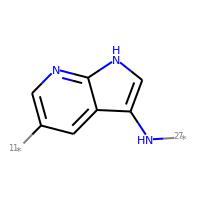
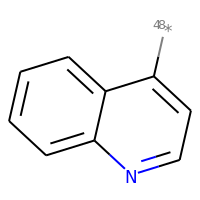
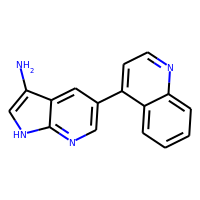
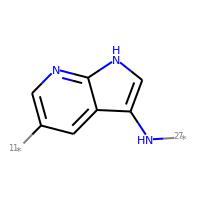
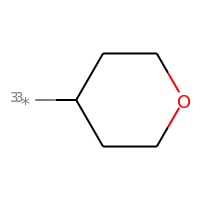
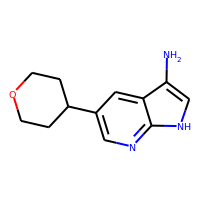
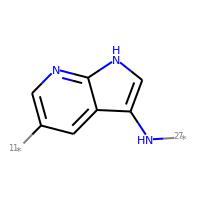
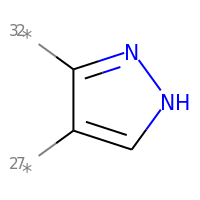
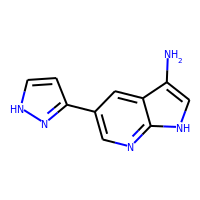
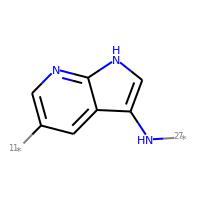
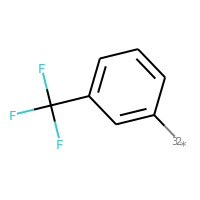
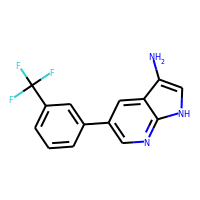
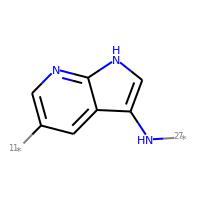
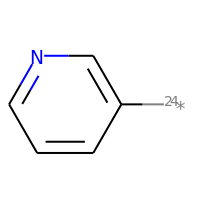
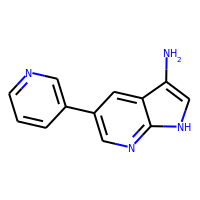
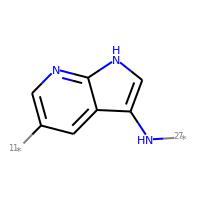
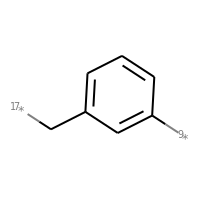
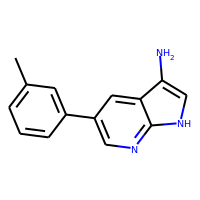
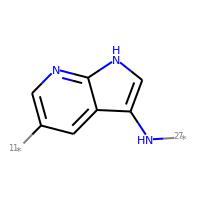
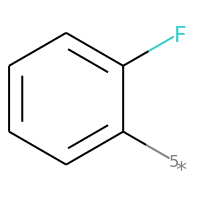
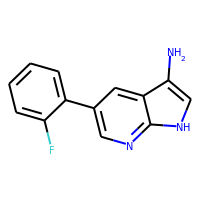
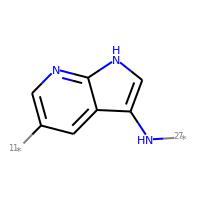
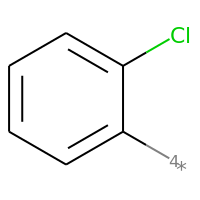
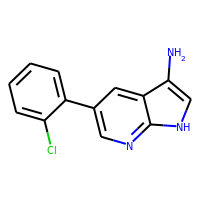
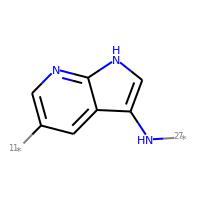
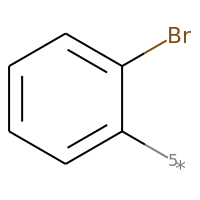
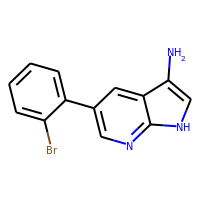
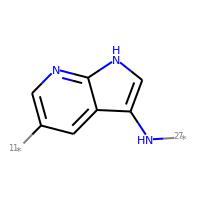
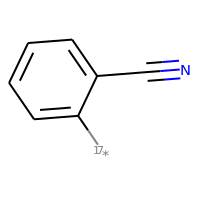
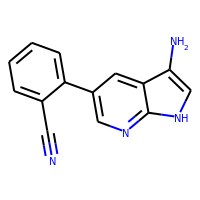
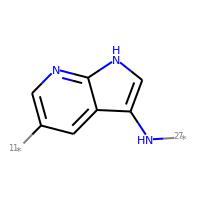
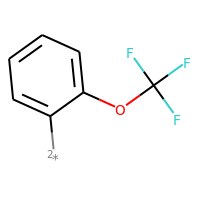
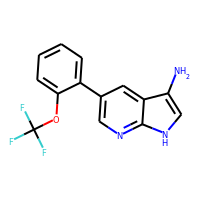
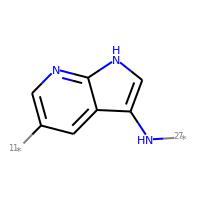
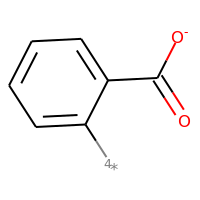
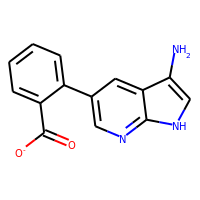
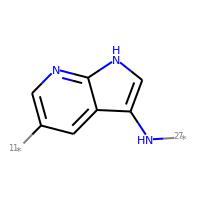
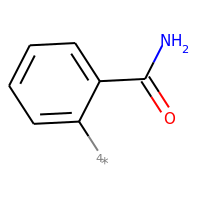
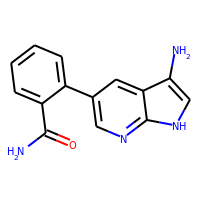

In [146]:
pairs_test = pair_df[0:20]
pairs_test

In [147]:
retro_df = get_retro(pairs_test, fragment_library_filtered)

/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'askcos.mit.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'askcos.mit.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'askcos.mit.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.w

ValueError: Length of values (0) does not match length of index (20)

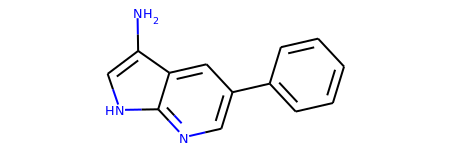

In [113]:
Chem.MolFromSmiles('Nc1c[nH]c2ncc(-c3ccccc3)cc12')